In [69]:
import platform

global systemDivide
if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

In [70]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

initParameters = {
    'yThreshold': 200,
    'rollingMean': 500,
    'fatRollingMean': 1000,
    'timeBarrier': 600,
    'varianceRatioFilter': 1.1,
    'restAfterLoss': 350,
    'restAfterFatProfit' : 350,
    'stopLossPercent': 20,
    'takeProfitPercent': 20,
    'varianceRatioCarreteParameter': 40,
    }

# Проверим распределение доходностей на нормальность

3 sigma anomalies 1.275%


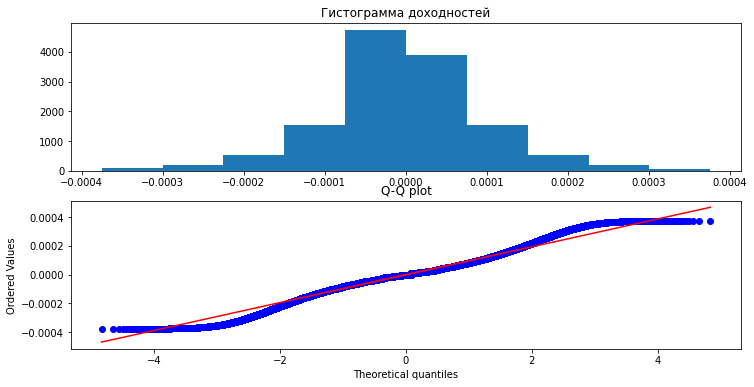

In [71]:
import matplotlib.pylab as plt
from scipy.stats import zscore, probplot

plt.style.use(style='fast')
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('Гистограмма доходностей')
abs_Z_scores = np.abs(zscore(inpData.open.pct_change().iloc[1:]))
filtered = (abs_Z_scores < 3)
print(f'3 sigma anomalies {(1 - sum(filtered) / inpData.shape[0]):.3%}')
bars = plt.hist(inpData.open.pct_change().values[1:][filtered], density=True, )
ax = plt.subplot(2,1,2)

probplot(inpData.open.pct_change().values[1:][filtered], plot=ax)
plt.title(f'Q-Q plot')
plt.show()
del abs_Z_scores, filtered, bars

In [72]:
def create_grid(params: initParameters):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        'capital': capital,
        'slippagePerCapital': slippage / capital,
        'yThreshold': round(params['yThreshold'] / 100, 2),
        'rollingMean': params['rollingMean'],
        'fatRollingMean': params['fatRollingMean'],
        'timeBarrier': params['timeBarrier'],
        'varianceRatioFilter': params['varianceRatioFilter'],
        'restAfterLoss': params['restAfterLoss'],
        'restAfterFatProfit' : params['restAfterFatProfit'],
        'stopLossThreshold': round(params['stopLossPercent'] / 100, 3),
        'takeProfitThreshold': round(params['takeProfitPercent'] / 100, 3),
        'varianceLookBack': params['rollingMean'] * 2,
        'varianceRatioCarrete': int((params['rollingMean'] * 2) // params['varianceRatioCarreteParameter']) + 1,
    }
    return retParams

def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['HBBand'] = df['rollMean'] + df['rollingStd'] * params['yThreshold']
    df['LBBand'] = df['rollMean'] - df['rollingStd'] * params['yThreshold']
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[max(params['varianceLookBack'], params['fatRollingMean']):]

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))
    sigma_b = (1 / m) * _buff_
    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(logTuple: tuple, retTuple: tuple, params: dict, timeBorderCounter: int) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
    _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
    sigma_b = (1 / m) * _buff_
    result = (sigma_b / sigma_a)
    if result > params['varianceRatioFilter']:
        return True
    else:
        return False

def open_position(arrowIndex, recursionFilter, LBandTuple, HBandTuple, LowTuple,
                 HighTuple, OpenTuple, params, logTuple, retTuple) -> dict:
    """
    Возвращает список с типом сделанной сделки
    :param arrowIndex: Навигация по полному массиву данных
    :param recursionFilter: ограничитель ошибок связанных с забитием памяти и превышением лимита рекурсии
    :param LBandTuple: нижняя граница болинджера
    :param HBandTuple: верхняя полоса болинджера
    :param LowTuple: low цена
    :param HighTuple: high цена
    :param OpenTuple: open цена
    :param params: список параметров полученных с помощью create_grid
    :param logTuple: необходим для расчета Variance ratio
    :param retTuple: необходим для расчета Variance ratio
    :return: список о сделанной сделке
    """
    _recursion_limit = 10_000

    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    if recursionFilter > _recursion_limit:
        return arrowIndex

    if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
        # Текущее открытие должно находится выше нижней полосы Болинджера,
        # тогда в случае если LOW пересекает полосу покупаем контракт по цене LBBand
        if (OpenTuple[arrowIndex] > LBandTuple[arrowIndex]) and (LowTuple[arrowIndex] < LBandTuple[arrowIndex]):
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = params['capital'] / LBandTuple[arrowIndex]
            openDict['openPrice'] = LBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = LBandTuple[arrowIndex] * (1 - params['stopLossThreshold'])
            openDict['takeProfitBorder'] = LBandTuple[arrowIndex] * (1 + params['takeProfitThreshold'])
            return openDict

        elif (OpenTuple[arrowIndex] < HBandTuple[arrowIndex]) and (HighTuple[arrowIndex] > HBandTuple[arrowIndex]):
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = -1 * (params['capital'] / HBandTuple[arrowIndex])
            openDict['openPrice'] = HBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = HBandTuple[arrowIndex] * (1 + params['stopLossThreshold'])
            openDict['takeProfitBorder'] = HBandTuple[arrowIndex] * (1 - params['takeProfitThreshold'])
            return openDict

        else:
            return open_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1, LBandTuple=LBandTuple,
                         HBandTuple=HBandTuple, LowTuple=LowTuple, HighTuple=HighTuple, OpenTuple=OpenTuple, params=params,
                         logTuple=logTuple, retTuple=retTuple)
    else:
        return open_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1, LBandTuple=LBandTuple,
                         HBandTuple=HBandTuple, LowTuple=LowTuple, HighTuple=HighTuple, OpenTuple=OpenTuple, params=params,
                         logTuple=logTuple, retTuple=retTuple)


def close_position(arrowIndex, recursionFilter, openDict, LowTuple, HighTuple, OpenTuple, LightMeanTuple, FatMeanTuple,
                   params, logTuple, retTuple, timeBorderCounter, indicatorVR) -> dict:
    """

    :param arrowIndex:
    :param recursionFilter:
    :param openDict:
    :param LowTuple:
    :param HighTuple:
    :param OpenTuple:
    :param LightMeanTuple:
    :param FatMeanTuple:
    :param params:
    :param logTuple:
    :param retTuple:
    :param timeBorderCounter:
    :param indicatorVR:
    :return:
    """
    _recursion_limit = 10_000
    NOT_NONE_SAVER = True

    if recursionFilter > _recursion_limit:
        return [arrowIndex, indicatorVR]

    if timeBorderCounter >= params['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': OpenTuple[arrowIndex+1],
                        'closeIndex': arrowIndex+1}

    elif openDict['typeOperation'] == 'BUY':
        # Stop Loss
        if LowTuple[arrowIndex] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (OpenTuple[arrowIndex] < LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if HighTuple[arrowIndex] > LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if LightMeanTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if OpenTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                if HighTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
        else:
            # Recursion next
            return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                      openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                      OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                      FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                      retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                      indicatorVR=indicatorVR)

    """================================================================================="""

    if openDict['typeOperation'] == 'SELL':
        # Stop Loss
        if HighTuple[arrowIndex] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (OpenTuple[arrowIndex] > LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть шорт о пересечение с малой скользящей
            if LowTuple[arrowIndex] < LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if LightMeanTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}
            else:
                return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                      openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                      OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                      FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                      retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                      indicatorVR=indicatorVR)

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if OpenTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                if LowTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
        else:
            # Recursion next
            return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                      openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                      OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                      FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                      retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                      indicatorVR=indicatorVR)

    if NOT_NONE_SAVER:
        return close_position(arrowIndex=arrowIndex + 1, recursionFilter=recursionFilter + 1,
                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                              retTuple=retTuple, timeBorderCounter=timeBorderCounter + 1,
                              indicatorVR=indicatorVR)


startParams = create_grid(initParameters)
cookedData = cook_data(df=inpData.copy(), params=startParams)

RESULT = list()
openPOS = open_position(arrowIndex=startParams['varianceLookBack'], recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

closePos = close_position(arrowIndex=openPOS['openIndex'], recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                          HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                          FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                          retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=False)
RESULT.append({**openPOS, **closePos})
openPOS = startParams['varianceLookBack'] + closePos['closeIndex']
for i in tqdm(range(450)):
    while type(openPOS) is not dict:
            openPOS = open_position(arrowIndex=openPOS, recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

    closePos = int(openPOS['openIndex'] + 1)
    indicatorVR = False
    while type(closePos) is not dict:
            closePos = close_position(arrowIndex=closePos, recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                              HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                              FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                              retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=indicatorVR)
            if type(closePos) == list:
                indicatorVR = closePos[1]
                closePos = closePos[0]

    total_dict = {**openPOS, **closePos}
    RESULT.append(total_dict)
    openPOS = closePos['closeIndex'] + 1

RESULT = pd.DataFrame(RESULT)

  0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
RESULT[RESULT.typeHolding == 'fatExtraProfit']

In [ ]:
RESULT[(RESULT.typeOperation == 'BUY') & (RESULT.typeHolding == 'endPeriod')]

In [ ]:
(RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - 2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - 2).cumsum()

In [ ]:
copy_df = RESULT.copy()
copy_df['profit'] = (RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - 2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - 2)
copy_df

In [ ]:
copy_df[(copy_df.typeHolding == 'fatExtraProfit') & (copy_df.profit > 0)]

In [ ]:
print(f"W={copy_df[copy_df.profit > 0].shape[0] / copy_df.shape[0]:.2%}, L = {copy_df[copy_df.profit < 0].shape[0] / copy_df.shape[0]:.2%}")
print(f'average profit of a positive trade: {copy_df[copy_df.profit > 0].profit.mean():.2f}')
print(f'average profit of a negative trade: {copy_df[copy_df.profit < 0].profit.mean():.2f}')

In [ ]:
print(f'average profit of a negative trade: {copy_df[(copy_df.profit < 0) & (copy_df.profit > -400)].profit.mean():.2f}')
plt.hist(copy_df[(copy_df.profit < 0) & (copy_df.profit > -400)].profit.values)

In [ ]:
copy_df[copy_df.profit < 0].groupby(by='typeHolding').describe()

In [ ]:
copy_df.groupby(by='typeHolding').describe()